In [22]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error


In [23]:
df=pd.read_excel(r'C:\Users\Asus\Downloads\dt\rop_12_input.xlsx')

In [24]:
df.tail()

,depth,WOB,SPPA,ECD,APRS,RPM,ROP
7448,2414.3984,13.1606,48.5325,1.3650,322.8411,177.3854,4.0201
7449,2414.5420,12.8619,48.5674,1.3660,323.0884,177.9275,3.8635
7450,2414.6850,12.9353,48.5391,1.3673,323.4332,179.1744,3.8501
7451,2414.8283,12.2109,48.5492,1.3690,323.8469,178.8186,3.7142
7452,2414.9813,7.7200,48.5896,1.3689,323.8469,178.2232,3.9388


In [25]:
random_state=2

In [26]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [27]:
# Specify the folder to save results
save_folder = f"decision_tree_results_{random_state}"
os.makedirs(save_folder, exist_ok=True)

In [28]:
# Define model and hyperparameter search space
model = DecisionTreeRegressor()
param_grid = {"max_depth": [3, 5, 10,], 
              "min_samples_split": [25, 35, 40], 
              "min_samples_leaf": [10,15,20,],
              'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
              'max_features': ['sqrt', 'log2',None],
              'splitter':['best','random']
              }

# Perform Grid Search with Cross-Validation
start_time = time.time()
gcv = GridSearchCV(model, param_grid, cv=5, scoring='r2',verbose=2)


gcv.fit(X_train, y_train)
training_time = time.time() - start_time


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, splitter=best; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_samples_leaf=10, min_samples_split=25, splitter=random; total time=   0.0s
[CV] END criterion=squared_error, max_depth=3, max_features=sqrt, min_sample

In [29]:
# Convert to hours, minutes, and seconds
hours = training_time // 3600
minutes = (training_time % 3600) // 60
seconds = training_time % 60

# Save training time
training_time_path = os.path.join(save_folder, "training_time.txt")

# Print the formatted time
print(f"Training time:{hours:.0f} hours {minutes:.0f} minutes {seconds:.2f} seconds")

# Optionally, save the training time to a file
with open(training_time_path, "w") as file:
    file.write(f"Training time:{hours:.0f} hours {minutes:.0f} minutes {seconds:.2f} seconds")

Training time:0 hours 5 minutes 1.36 seconds


In [30]:
# Print best parameters
best_params = gcv.best_params_
print("Best Parameters:", best_params)
pd.DataFrame([best_params]).to_csv(os.path.join(save_folder, "best_params.csv"), index=False)


Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 40, 'splitter': 'best'}


In [31]:
# Print and save cross-validation results
cv_results = pd.DataFrame(gcv.cv_results_)
print("Cross-Validation Results:\n", cv_results)
cv_results.to_csv(os.path.join(save_folder, "cv_results.csv"), index=False)


Cross-Validation Results:
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.007745      0.001508         0.001936        0.001760   
1         0.006268      0.006137         0.002069        0.001109   
2         0.007083      0.003969         0.002445        0.003964   
3         0.003884      0.000749         0.002439        0.000691   
4         0.004424      0.003638         0.004862        0.006576   
..             ...           ...              ...             ...   
643       0.009486      0.001519         0.002531        0.000870   
644       0.039127      0.002085         0.002474        0.000414   
645       0.009117      0.001795         0.002998        0.001651   
646       0.039486      0.001981         0.004342        0.002666   
647       0.008863      0.000640         0.001751        0.001411   

    param_criterion  param_max_depth param_max_features  \
0     squared_error                3               sqrt   
1     squared_error       

In [32]:
# Extract R² values from each fold (it is stored in 'mean_test_score' for regression tasks)
cv_results['R²'] = cv_results['mean_test_score']  # 'mean_test_score' holds the average score across all folds

for i in range(gcv.n_splits_):  # gcv.n_splits_ gives the number of splits
    cv_results[f'R2_fold_{i+1}'] = cv_results[f'split{i}_test_score']

# Save the updated results with individual fold R² scores
cv_results.to_csv(os.path.join(save_folder, "cv_results_with_folds.csv"), index=False)

print("Cross-validation results with R² saved successfully.")


Cross-validation results with R² saved successfully.


In [33]:
import os
import pandas as pd

# Extract the best hyperparameter combination
best_params = gcv.best_params_
fold_r2 = [cv_results[f'split{i}_test_score'].mean() for i in range(gcv.n_splits_)]
# Extract the R² for the best hyperparameter combination in each fold
best_fold_r2 = []

# Loop through each fold and get the R² for the best combination
for i in range(gcv.n_splits_):
    # Compare the parameter dictionary for each fold
    best_fold_r2.append(cv_results[f'split{i}_test_score'][cv_results['params'].apply(lambda x: x == best_params)].values[0])


# Print the R² for each fold
print("R2 for each fold:", fold_r2)
# Print the R² for the best combination in each fold
print("R² for the best combination in each fold:", best_fold_r2)

# Save the R² values for each fold to a CSV file
fold_r2_best = pd.DataFrame(fold_r2, columns=["Each fold R2"])
fold_r2_best["Best Combination R2"] = best_fold_r2
fold_r2_best.to_csv(os.path.join(save_folder, "r2_folds_best_combi.csv"), index=False)


print("R² values for each fold and best combination saved successfully.")


R2 for each fold: [0.08378977184655136, -79.73222970321126, 0.047427924111382795, -36.52906993220708, -0.12262658536912377]
R² for the best combination in each fold: [0.0034822669008434115, 0.804710956743959, 0.0024872564058255886, 0.7489363648631724, 0.004635611661113259]
R² values for each fold and best combination saved successfully.


In [34]:
# Train best model
best_model = gcv.best_estimator_
best_model.fit(X_train, y_train)


DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=10, min_samples_split=40)

In [35]:
# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_whole_pred = best_model.predict(X)

In [36]:
# Create a single Excel file with multiple sheets
excel_path = os.path.join(save_folder, "results.xlsx")
with pd.ExcelWriter(excel_path) as writer:
    pd.DataFrame({"y_test": y_test, "y_test_pred": y_test_pred}).to_excel(writer, sheet_name="Test", index=False)
    pd.DataFrame({"y_train": y_train, "y_train_pred": y_train_pred}).to_excel(writer, sheet_name="Train", index=False)
    pd.DataFrame({"y_whole": y, "y_whole_pred": y_whole_pred}).to_excel(writer, sheet_name="Whole", index=False)

In [37]:
# Compute and save metrics
metrics = {
    "Train": {
        "R2": r2_score(y_train, y_train_pred),
        "RMSE": root_mean_squared_error(y_train, y_train_pred),
        "MSE": mean_squared_error(y_train, y_train_pred),
        "MAE": mean_absolute_error(y_train, y_train_pred),
        "MAPE": mean_absolute_percentage_error(y_train, y_train_pred),
        "MaxE": np.max(np.abs(y_train - y_train_pred)),
        "MinE": np.min(np.abs(y_train - y_train_pred)),
    },
    "Test": {
        "R2": r2_score(y_test, y_test_pred),
        "RMSE": root_mean_squared_error(y_test, y_test_pred),
        "MSE": mean_squared_error(y_test, y_test_pred),
        "MAE": mean_absolute_error(y_test, y_test_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_test_pred),
        "MaxE": np.max(np.abs(y_test - y_test_pred)),
        "MinE": np.min(np.abs(y_test - y_test_pred)),
    },
    "Whole": {
        "R2": r2_score(y, y_whole_pred),
        "RMSE": root_mean_squared_error(y, y_whole_pred),
        "MSE": mean_squared_error(y, y_whole_pred),
        "MAE": mean_absolute_error(y, y_whole_pred),
        "MAPE": mean_absolute_percentage_error(y, y_whole_pred),
        "MaxE": np.max(np.abs(y - y_whole_pred)),
        "MinE": np.min(np.abs(y - y_whole_pred)),
    }
}
metrics_df = pd.DataFrame(metrics)
metrics_csv_path = os.path.join(save_folder, "metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=True)

metrics_df

,Train,Test,Whole
R2,0.004683,0.005173,0.004845
RMSE,397.888812,172.603400,346.058825
MSE,158315.507093,29791.933709,119756.710624
MAE,16.072416,8.338224,13.752055
MAPE,0.170142,0.197724,0.178417
MaxE,14375.093900,7174.391800,14375.093900
MinE,0.000000,0.000000,0.000000


In [38]:
print("Results saved in folder:", save_folder)

Results saved in folder: decision_tree_results_2


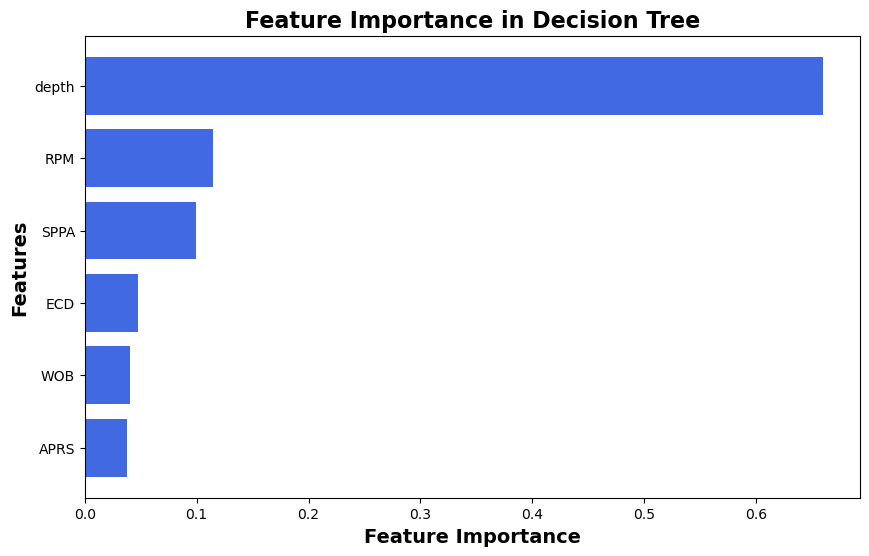

In [39]:

feature_importances = best_model.feature_importances_

# Convert to DataFrame for sorting and visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
feature_importance= os.path.join(save_folder, "feature_importance.csv")
# Plot feature importance as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel("Feature Importance", fontsize=14, fontweight='bold')
plt.ylabel("Features", fontsize=14, fontweight='bold')
plt.title("Feature Importance in Decision Tree", fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.savefig(os.path.join(save_folder, "feature_importance.png"),dpi=1000)
plt.show()



In [40]:
import joblib
# Save the trained model
model_path = os.path.join(save_folder, "best_model.pkl")
joblib.dump(best_model, model_path)

['decision_tree_results_2\\best_model.pkl']

In [41]:
# Load the saved model
# loaded_model = joblib.load(model_path)
# y_pred_loaded = loaded_model.predict(X_test)


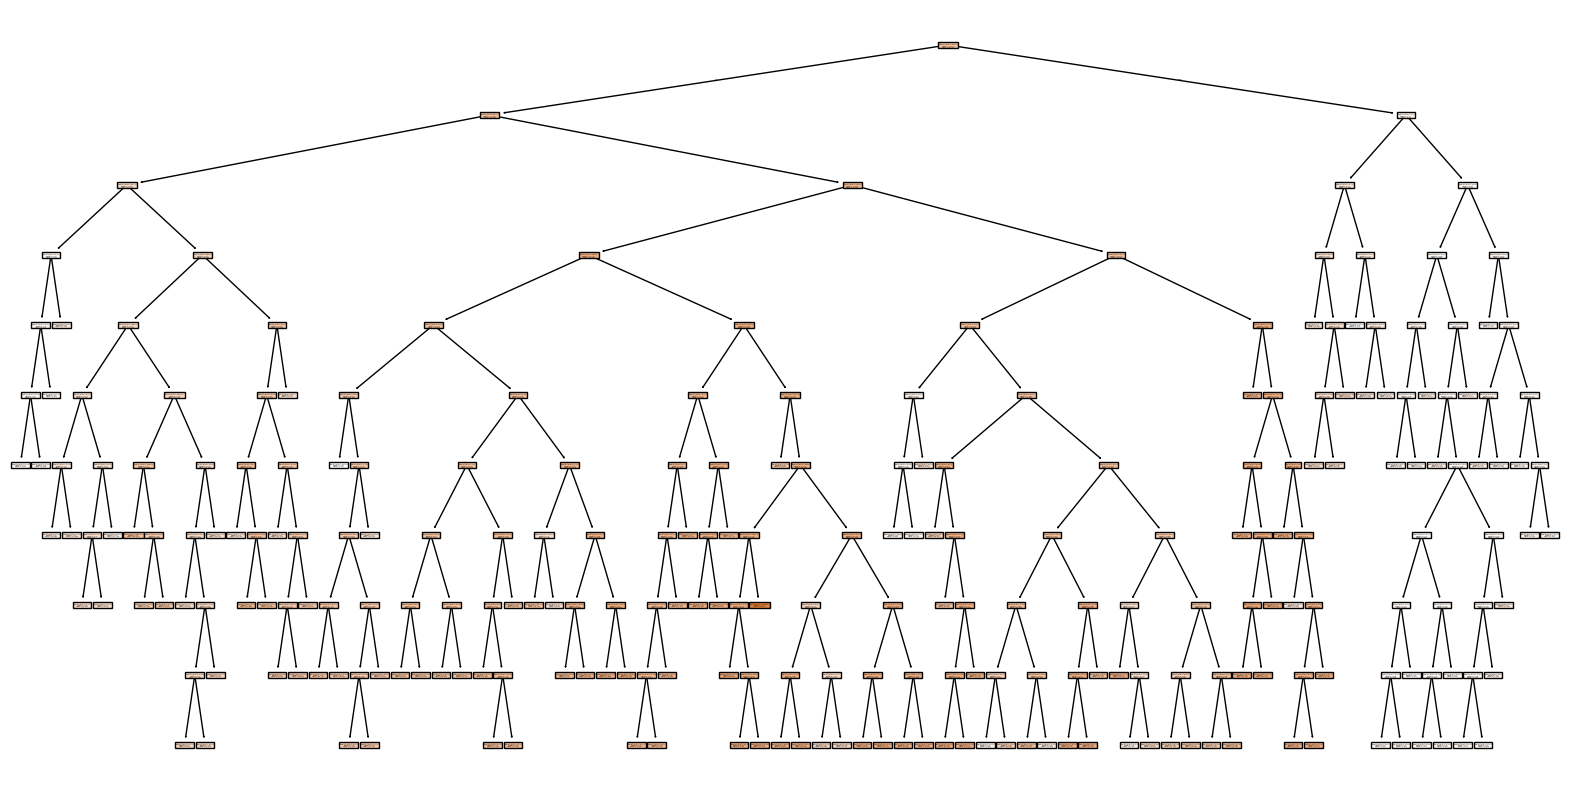

In [42]:

from sklearn.tree import plot_tree

# Assuming 'model' is your trained DecisionTreeRegressor or DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Adjust figure size for better readability
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=True)
plt.show()
